In [2]:
import numpy.typing as npt
import numpy as np
from typing import Union
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import yfinance
from scipy.stats import gaussian_kde
# own module
from simulations.fractional_brownian import (
    generate_brownian_path,
    generate_n_assets_portfolio,
)
from backtest.backtester import Backtester
from strategy.strategy import SalopekStrategy
from utility.utils import (
    generate_t,
    a_order_power_mean,
    transaction_cost_L,
    compute_empirical_hurst_exponent,
)

In [3]:
t, s_t = generate_brownian_path(
    n_steps=250, T=1, H=0.8, mu=0.15, sigma=0.2, s0=100, brownian_type="fractional"
)

Price process : $$s^i_t=s^i_0\times e^{\mu^it+\sigma^iB_t^{H^i}}$$


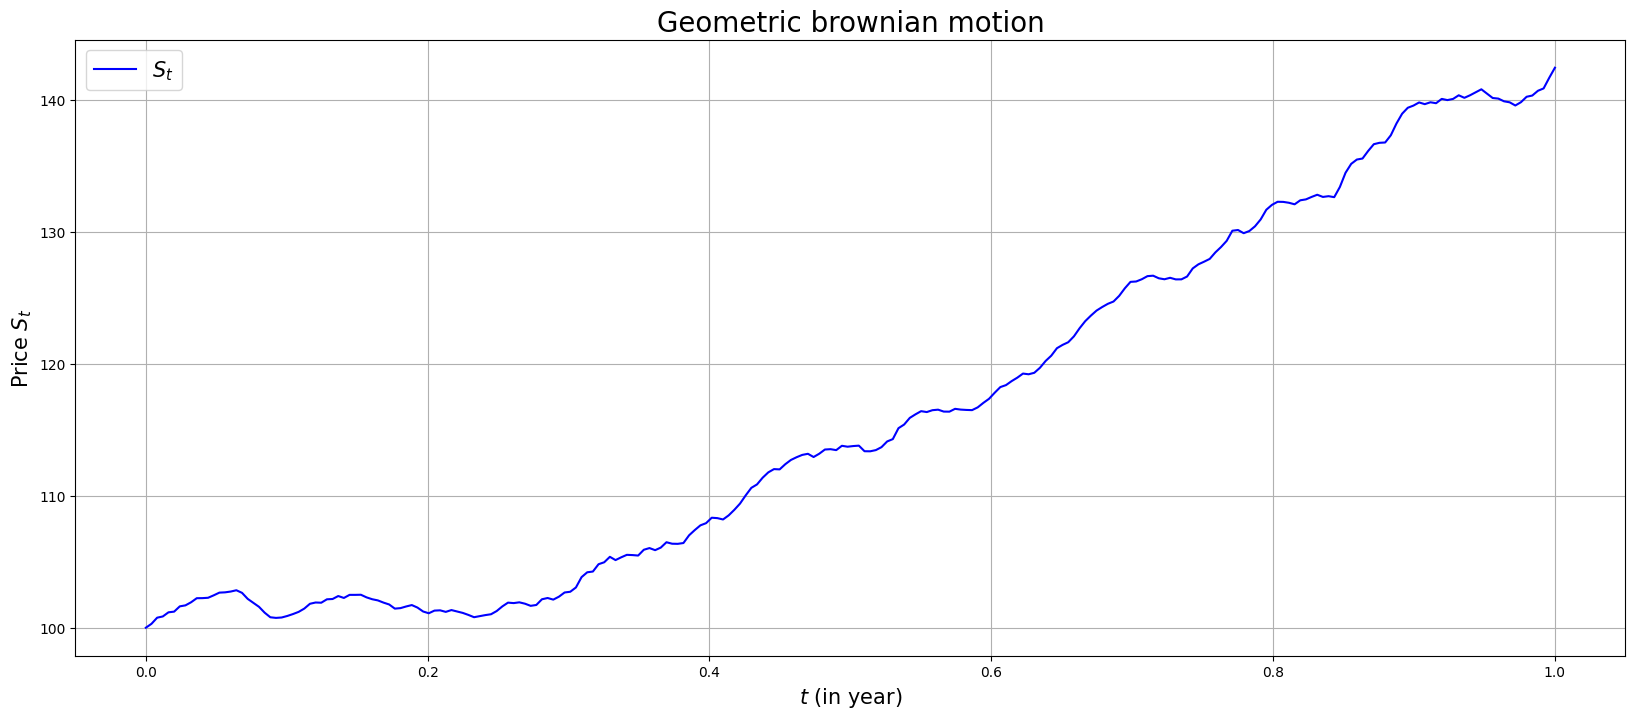

In [4]:
_, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(
    t,
    s_t,
    color="blue",
    label="$S_t$",
)

ax.set_xlabel("$t$ (in year)", fontsize=15)
ax.set_ylabel("Price $S_t$", fontsize=15)
ax.set_title(f"Geometric brownian motion", fontsize=20)
ax.grid()
ax.legend(fontsize=15)

- Portfolio value at time $t$ : $$V^\Psi_t=\sum^d_{i=0}\Psi_t^iS_t^i$$
- Gain process at time $t$ : $$G^\Psi_t=\sum^d_{i=0}\int_0^t\Psi_t^idS_t^i$$
- Portfolio value at time $t$ : $$V^\Psi_t=\nu+G^\Psi_t$$


# Salopek strategy

Another arbitrage strategy, dating back to Harrison et al. (1984) and applied in a fractional Black-Scholes market by Salopek (1998), trades $d \geq 2$ risky assets and ignores the risk-free asset. It is defined for two real-valued constants $\alpha<\beta$ and can be summarized as $\Psi=(0, \Psi(\alpha, \beta))$ or, with some abuse of notation, $\Psi=\Psi(\alpha, \beta)$. The entries of $\Psi(\alpha, \beta)=\left(\Psi_{t}^{1}(\alpha, \beta), \ldots, \Psi_{t}^{d}(\alpha, \beta)\right)$ are the risky asset shares at time $t \in[0, T]$. Specifically, for $i=1, \ldots, d$, we have

$$
\begin{equation*}
\Psi_{t}^{i}(\alpha, \beta)=\widehat{\Psi}_{t}^{i}(\beta)-\widehat{\Psi}_{t}^{i}(\alpha), \quad \text { where } \quad \widehat{\Psi}_{t}^{i}(a)=\frac{1}{d}\left(\frac{S_{t}^{i}}{M_{a}\left(S_{t}\right)}\right)^{a-1} \tag{2.10}
\end{equation*}
$$

$M_{a}(x)$ denotes the $a$-order power mean of $x=\left(x^{1}, \ldots, x^{d}\right) \in \mathbb{R}_{+}^{d}$. It is given by

$$
\begin{array}{ll}
M_{a}(x)=\left(\frac{1}{d} \sum_{i=1}^{d}\left(x^{i}\right)^{a}\right)^{1 / a} \quad \text { for } \quad a \neq 0  \tag{2.11}\\
M_{0}(x)=\sqrt[d]{x^{1} \cdot \ldots \cdot x^{d}} \quad \text { for } \quad a=0
\end{array}
$$

Remark 2.2 With respect to the properties of the a-order power mean, we can list the following important special cases:

$$
\begin{aligned}
& M_{1}(x)=\left(x^{1}+\ldots+x^{d}\right) / d \quad \text { (arithmetic mean) } \\
& M_{2}(x)=\sqrt{\left(\left(x^{1}\right)^{2}+\ldots+\left(x^{d}\right)^{2}\right) / d} \quad \text { (quadratic mean) } \\
& M_{-1}(x)=\left(\left(1 / x^{1}+\ldots+1 / x^{d}\right) / d\right)^{-1} \quad \text { (harmonic mean) } \\
& M_{0}(x)=\sqrt[d]{x^{1} \cdot \ldots \cdot x^{d}}=\lim _{a \rightarrow 0} M_{a}(x) \quad \text { (geometric mean) } \\
& M_{\infty}(x):=\lim _{a \rightarrow+\infty} M_{a}(x)=x_{\max }=\max \left\{x^{1}, \ldots, x^{d}\right\} \quad(\text { maximum of } x) \\
& M_{-\infty}(x):=\lim _{a \rightarrow-\infty} M_{a}(x)=x_{\min }=\min \left\{x^{1}, \ldots, x^{d}\right\} \quad(\text { minimum of } x)
\end{aligned}
$$

The strategy $\Psi(\alpha, \beta)$ in (2.10) is expressed as the difference between $\widehat{\Psi}(\beta)$ and $\widehat{\Psi}(\alpha)$. Because these two components can be considered as strategies themselves, we call $\widehat{\Psi}(a)$ an a-strategy or a-portfolio. Consequently, an investor can implement $\Psi(\alpha, \beta)$ by purchasing a $\beta$-portfolio and short-selling an $\alpha$-portfolio.

Substituting the $\widehat{\Psi}(a)$ specified by (2.10) into (2.5) provides the portfolio value of an $a$-strategy, i.e., we obtain

$$
\begin{equation*}
V_{t}^{\widehat{\Psi}(a)}=M_{a}\left(S_{t}\right) . \tag{2.13}
\end{equation*}
$$


In [20]:
df_ptf = generate_n_assets_portfolio(
    5,
    n_steps=250,
    T=1,
    H=0.7,
    mu=0.05,
    sigma=0.1,
    s0=100,
    add_risk_free_asset=False,
    as_dataframe=True,
    brownian_type="fractional",
)
df_ptf

,S_1_t,S_2_t,S_3_t,S_4_t,S_5_t
0.000000,100.000000,100.000000,100.000000,100.000000,100.000000
0.004016,100.143669,100.317925,99.995350,99.905979,100.151700
0.008032,100.088737,100.476779,99.990183,100.142306,99.975173
0.012048,99.433019,100.525383,100.184773,100.086257,99.900738
0.016064,99.206433,100.565678,100.270975,99.905137,100.005502
...,...,...,...,...,...
0.983936,119.543716,98.776983,108.369722,111.856870,108.766764
0.987952,119.299629,98.748788,108.658344,111.847783,108.898282
0.991968,119.427449,98.655508,108.538849,111.994238,108.856935
0.995984,119.343634,98.596081,108.737340,112.340328,108.672169


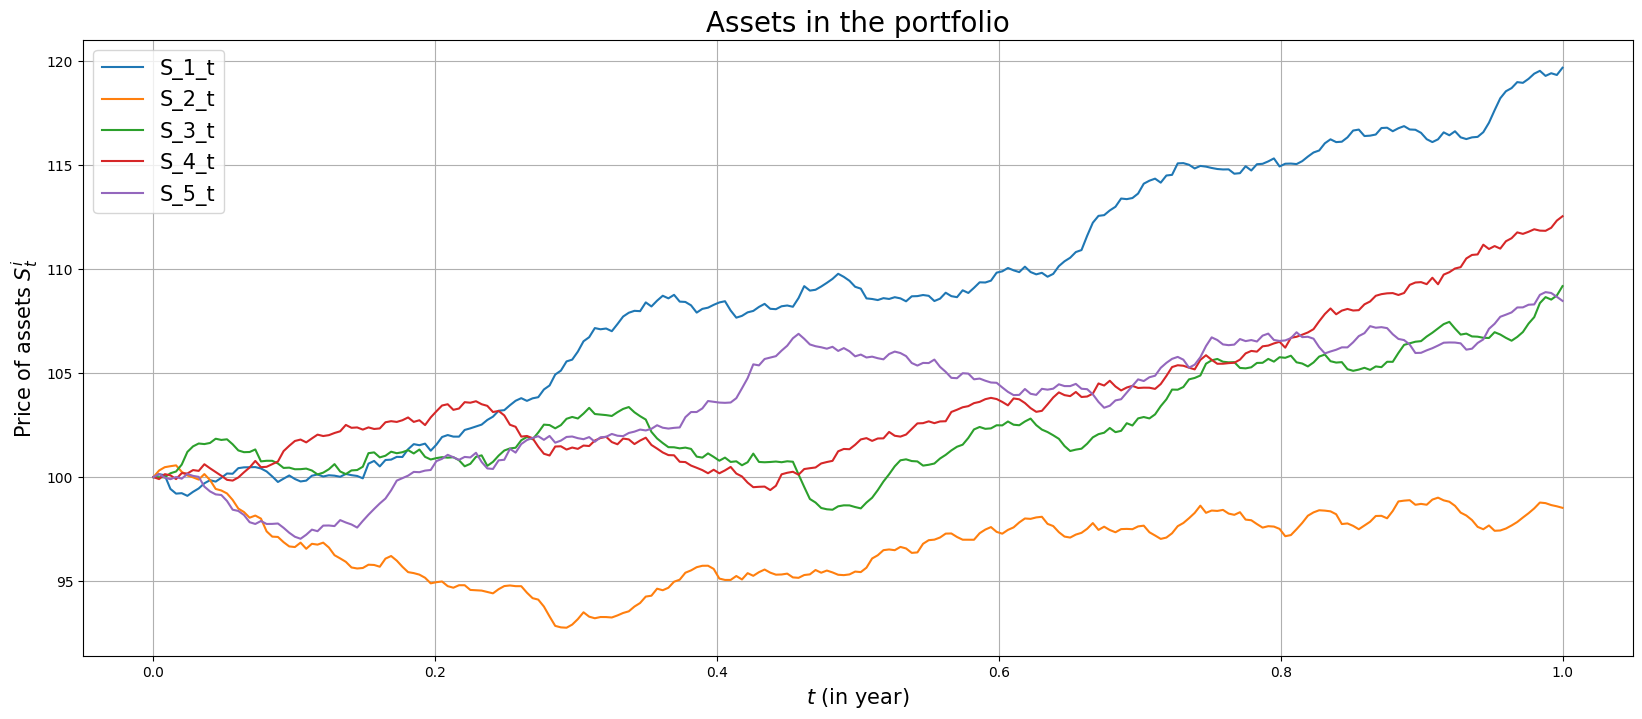

In [21]:
_, ax = plt.subplots(1, 1, figsize=(20, 8))
for col in df_ptf.columns:
    ax.plot(
        df_ptf[col],
        label=f"{col}",
    )

ax.set_xlabel("$t$ (in year)", fontsize=15)
ax.set_ylabel("Price of assets $S_t^i$", fontsize=15)
ax.set_title(f"Assets in the portfolio", fontsize=20)
ax.grid()
ax.legend(fontsize=15)

$$\Psi_t^i(a)=\frac{1}{d}\times(\frac{S_t^i}{M_a(S_t)})^{a-1}$$
and $$\Phi_n^i=\Psi_{t-1}^i \quad i=1,...,d$$


Transaction cost : $$L_t^\Phi=l(\Gamma_t^\Phi,p) \quad \text { with } \quad l(y,p)=max(p_1y,p_2)\mathbb{1}_{\{y>0\}}$$
And $p=(p_1,p_2)$

Liquidation :

$$R^\Phi=\sum_{i=0}^d\Phi_N^iS_T^i-L^\Phi_T$$


# Running the strategy

## Salopek


In [22]:
ALPHA = -30
BETA = 30

# fees (no fees now)
P1 = 0  # 0.1 proportionality factor p1 (in percent)
P2 = 0  # 0.5 minimum fee p2 (in monetary units)

SCALING_FACTOR = 100  # \gamma

salopek_strat = SalopekStrategy(alpha=ALPHA, beta=BETA, scaling_factor=SCALING_FACTOR)

bk_tester = Backtester()

weights_df, V_t_psi, V_t_phi, transaction_account = bk_tester.run_backtest(
    universe_dataframe=df_ptf,
    allocation_function=salopek_strat.get_allocation,
    p1=P1,
    p2=P2,
)

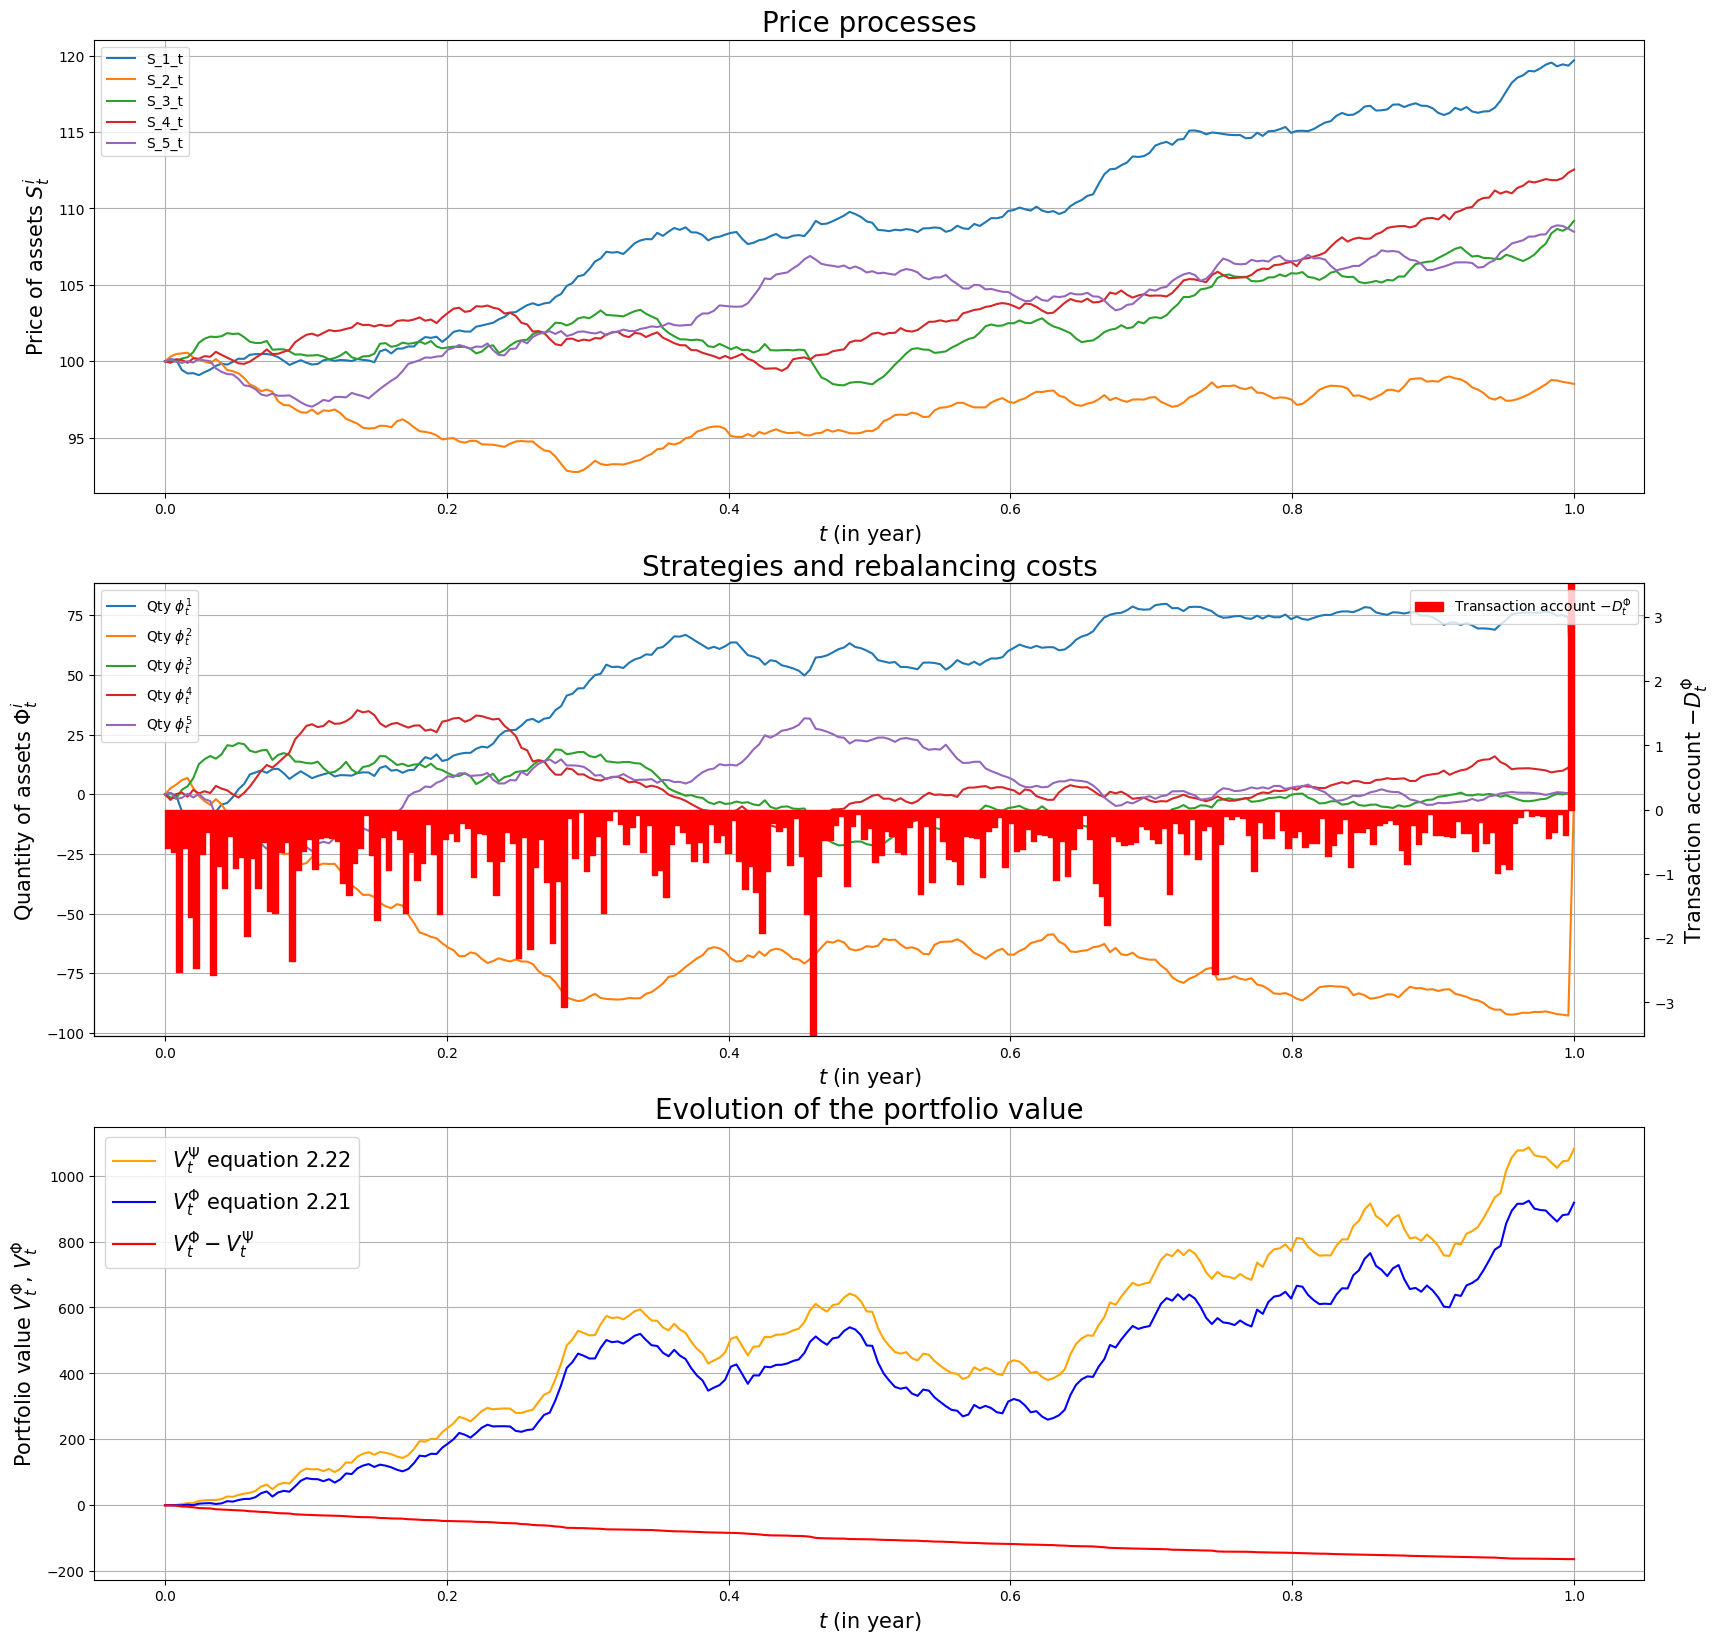

In [23]:
_, ax = plt.subplots(3, 1, figsize=(20, 20))
for col in df_ptf.columns:
    ax[0].plot(
        df_ptf[col],
        label=f"{col}",
    )

ax[0].set_xlabel("$t$ (in year)", fontsize=15)
ax[0].set_ylabel("Price of assets $S_t^i$", fontsize=15)
ax[0].set_title(f"Price processes", fontsize=20)
ax[0].grid()
ax[0].legend(fontsize=10)

for col in weights_df.columns:
    ax[1].plot(
        weights_df[col],
        label=r"Qty $\{}_t$".format(col.replace("_", "^")),
    )
ax_l = ax[1].twinx()
ax_l.fill_between(
    df_ptf.index,
    -transaction_account,
    color="red",
    step="pre",
    label=r"Transaction account $-D_t^\Phi$",
)

ax[1].set_xlabel("$t$ (in year)", fontsize=15)
ax[1].set_ylabel(r"Quantity of assets $\Phi_t^i$", fontsize=15)
ax_l.set_ylabel(r"Transaction account $-D_t^\Phi$", fontsize=15)
ax_l.set_ylim([-max(transaction_account), max(transaction_account)])
ax[1].set_title(f"Strategies and rebalancing costs", fontsize=20)
ax[1].grid()
ax[1].legend(fontsize=10, loc="upper left")
ax_l.legend(fontsize=10, loc="upper right")
# ax_l2 = ax[2].twinx()
ax[2].plot(df_ptf.index, V_t_psi, label=r"$V_t^\Psi$ equation 2.22", color="orange")
ax[2].plot(
    df_ptf.index,
    V_t_phi,
    # linestyle="--",
    label=r"$V_t^\Phi$ equation 2.21",
    color="blue",
)
ax[2].plot(
    df_ptf.index,
    V_t_phi - V_t_psi,
    label=r"$V_t^\Phi-V_t^\Psi$",
    color="red",
)

ax[2].set_xlabel("$t$ (in year)", fontsize=15)
ax[2].set_ylabel(r"Portfolio value $V_t^\Phi$, $V_t^\Phi$", fontsize=15)
ax[2].set_title(f"Evolution of the portfolio value", fontsize=20)
ax[2].grid()
# ax_l2.legend(fontsize=15, loc="upper left")
ax[2].legend(fontsize=15, loc="upper left")

# Real data


In [10]:
df_ptf = pd.read_csv("../data/data_engie_axa.csv", sep=";").dropna()
df_ptf["Date"] = pd.to_datetime(df_ptf["Date"],dayfirst=True)
df_ptf = df_ptf.set_index("Date").sort_index()
df_ptf

,ENGI FP Equity,CS FP Equity,RTY Index,SPX Index,SX5E Index,SXXP Index
Date,,,,,,
2006-01-30,26.10,26.7691,730.885,1285.20,3677.52,321.07
2006-01-31,26.01,26.7403,733.215,1280.09,3691.41,321.04
2006-02-01,26.37,26.9703,735.497,1282.46,3728.34,324.48
2006-02-02,26.40,26.5295,726.265,1270.84,3677.05,321.56
2006-02-03,26.56,26.4240,724.232,1264.03,3678.48,321.77
...,...,...,...,...,...,...
2024-04-15,15.74,33.8200,1975.708,5061.82,4984.48,505.93
2024-04-16,15.71,33.2200,1967.475,5051.41,4916.99,498.21
2024-04-17,15.73,33.4600,1947.947,5022.21,4914.13,498.52


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,ENGI FP Equity,CS FP Equity,RTY Index,SPX Index,SX5E Index,SXXP Index,^TNX,^IBEX,QQQ,EURUSD=X,...,JPYUSD=X,GBP=X,TTF=F,^DJI,GC=F,^FVX,BZ=F,^AEX,HTT=F,BTC-USD
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-23,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2017-10-24,99.555404,101.225781,100.195527,100.161795,100.050431,99.639146,101.262625,100.435962,100.169216,100.047040,...,100.624674,99.873379,99.281365,100.720972,99.788687,100.996511,101.673354,99.580548,101.856147,93.192952
2017-10-25,97.400821,100.988533,99.731952,99.694734,99.517578,99.076112,102.861956,99.920281,99.790163,100.045864,...,100.089518,100.440541,100.110561,100.238464,99.819995,102.441456,101.865086,99.140962,101.856147,96.972844
2017-10-26,98.837209,102.095690,99.997796,99.821441,100.785010,100.135640,103.198652,101.834387,99.472046,100.570942,...,100.431500,99.369527,99.889439,100.545238,99.107779,103.089190,103.364128,100.313203,102.320183,99.570179
2017-10-27,99.179207,101.838671,100.722809,100.627295,101.201484,100.688437,102.188554,100.355262,102.369027,99.009673,...,99.933403,100.453733,100.331672,100.688445,99.279960,101.793723,105.351228,100.637406,102.320183,97.480407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-15,107.660739,133.728747,131.934461,197.343449,138.117472,129.479961,194.781142,105.174482,291.769312,90.607029,...,74.403552,105.841776,172.155884,162.134454,185.160847,231.439963,157.050724,161.929440,40.603249,1069.524289
2024-04-16,107.455540,131.356267,131.384675,196.937598,136.247357,127.504223,196.085861,103.596945,291.796392,90.403879,...,73.958212,105.964443,183.189606,162.408835,187.117488,233.283519,156.911275,160.207698,40.603249,1076.027351
2024-04-17,107.455540,131.356267,131.384675,196.937598,136.247357,127.504223,196.085861,103.596945,291.796392,90.403879,...,73.958212,105.964443,183.189606,162.408835,187.117488,233.283519,156.911275,160.207698,40.603249,1076.027351


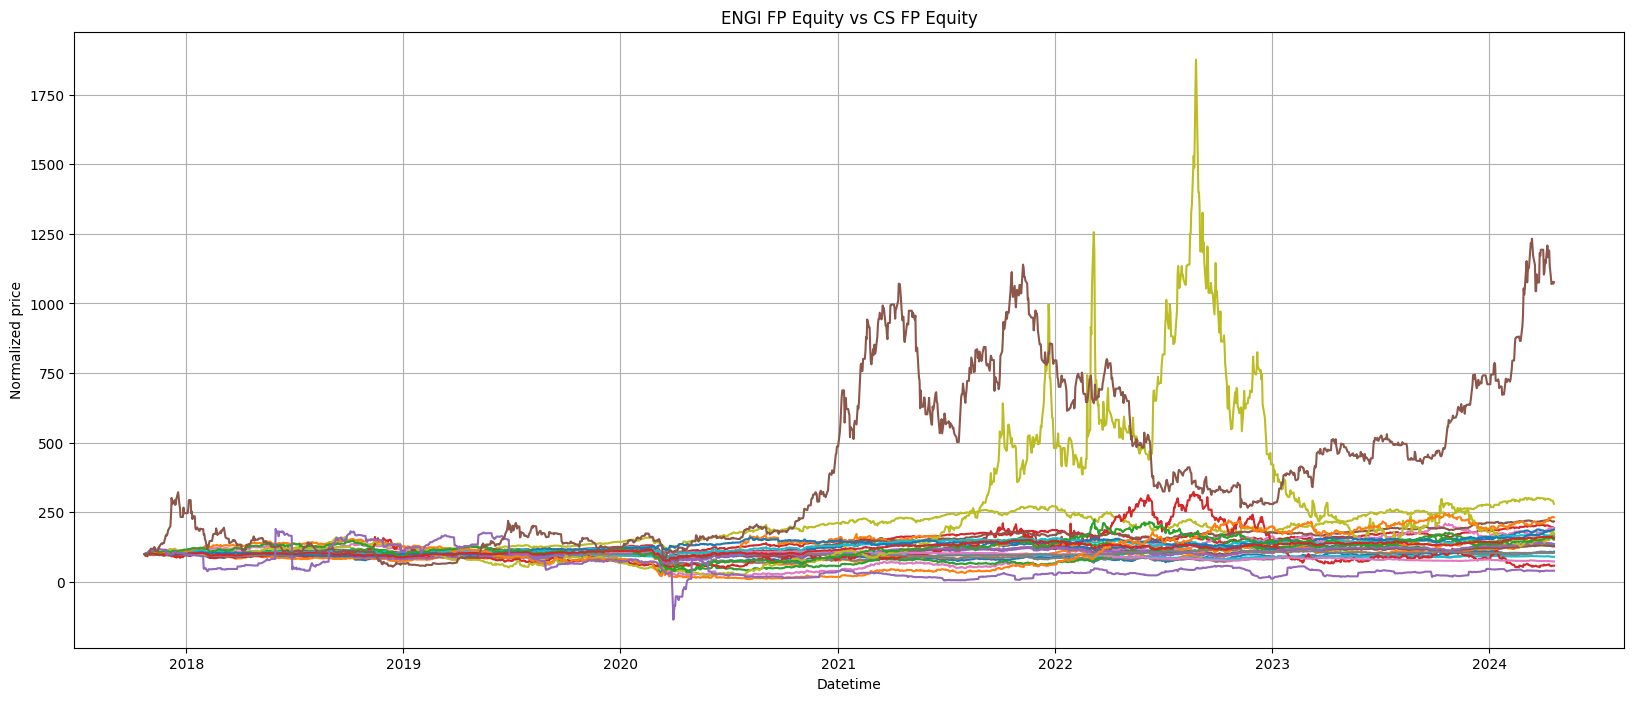

In [11]:
for ticker in set((
    "^IBEX",
    "GBP=X",
    "SI=F",
    "NG=F",
    "^GDAXI",
    "^N225",
    "^TNX",
    "TTF=F",
    "^AEX",
    "EURUSD=X",
    "^FVX",
    "^TYX",
    "^DJI",
    "JPYUSD=X",
    "^NSEI",
    "GC=F",
    "HTT=F",
    "BZ=F",
    "QQQ",
    "BTC-USD",
)):
    df_ticker = yfinance.download(ticker,start="2016-01-01")[["Close"]].rename(
        columns={"Close": ticker}
    )
    df_ptf = df_ptf.merge(df_ticker, left_index=True, right_index=True)

df_ptf = df_ptf.resample("1B").ffill()  # .loc["2022-03-01":]
df_ptf = (df_ptf.pct_change().fillna(99) + 1).cumprod()


plt.figure(figsize=(20, 8))
for col in df_ptf.columns:
    plt.plot(
        df_ptf[col],
        label=col,
    )

plt.xlabel("Datetime")
plt.ylabel("Normalized price")
plt.title("ENGI FP Equity vs CS FP Equity")
plt.grid()
# plt.legend()

df_ptf

In [12]:
t = generate_t(df_ptf.shape[0], T=df_ptf.shape[0] / 252)

for col in df_ptf.columns:
    print(f"{col} : H={compute_empirical_hurst_exponent(df_ptf[col].to_numpy(),t):.5f}")

ENGI FP Equity : H=0.44507
CS FP Equity : H=0.49987
RTY Index : H=0.46315
SPX Index : H=0.44400
SX5E Index : H=0.48698
SXXP Index : H=0.48308
^TNX : H=0.49928
^IBEX : H=0.49559
QQQ : H=0.44256
EURUSD=X : H=0.49984
^N225 : H=0.49992
SI=F : H=0.49948
^TYX : H=0.49799
NG=F : H=0.49975
^GDAXI : H=0.48240
^NSEI : H=0.48675
JPYUSD=X : H=0.49987
GBP=X : H=0.49710
TTF=F : H=0.49354
^DJI : H=0.45732
GC=F : H=0.49982
^FVX : H=0.49999
BZ=F : H=0.48989
^AEX : H=0.48375
HTT=F : H=0.49991
BTC-USD : H=0.49997


In [13]:
ALPHA = -30
BETA = 30

# fees (no fees now)
P1 = 0.1  # 0.1 proportionality factor p1 (in percent)
P2 = 0.5  # 0.5 minimum fee p2 (in monetary units)

SCALING_FACTOR = 100  # \gamma


salopek_strat = SalopekStrategy(alpha=ALPHA, beta=BETA)

df_backtest = df_ptf[["QQQ","SPX Index"]]
bk_tester = Backtester()

weights_df, V_t_psi, V_t_phi, transaction_account = bk_tester.run_backtest(
    universe_dataframe=df_backtest,
    allocation_function=salopek_strat.get_allocation,
    p1=P1,
    p2=P2,
)

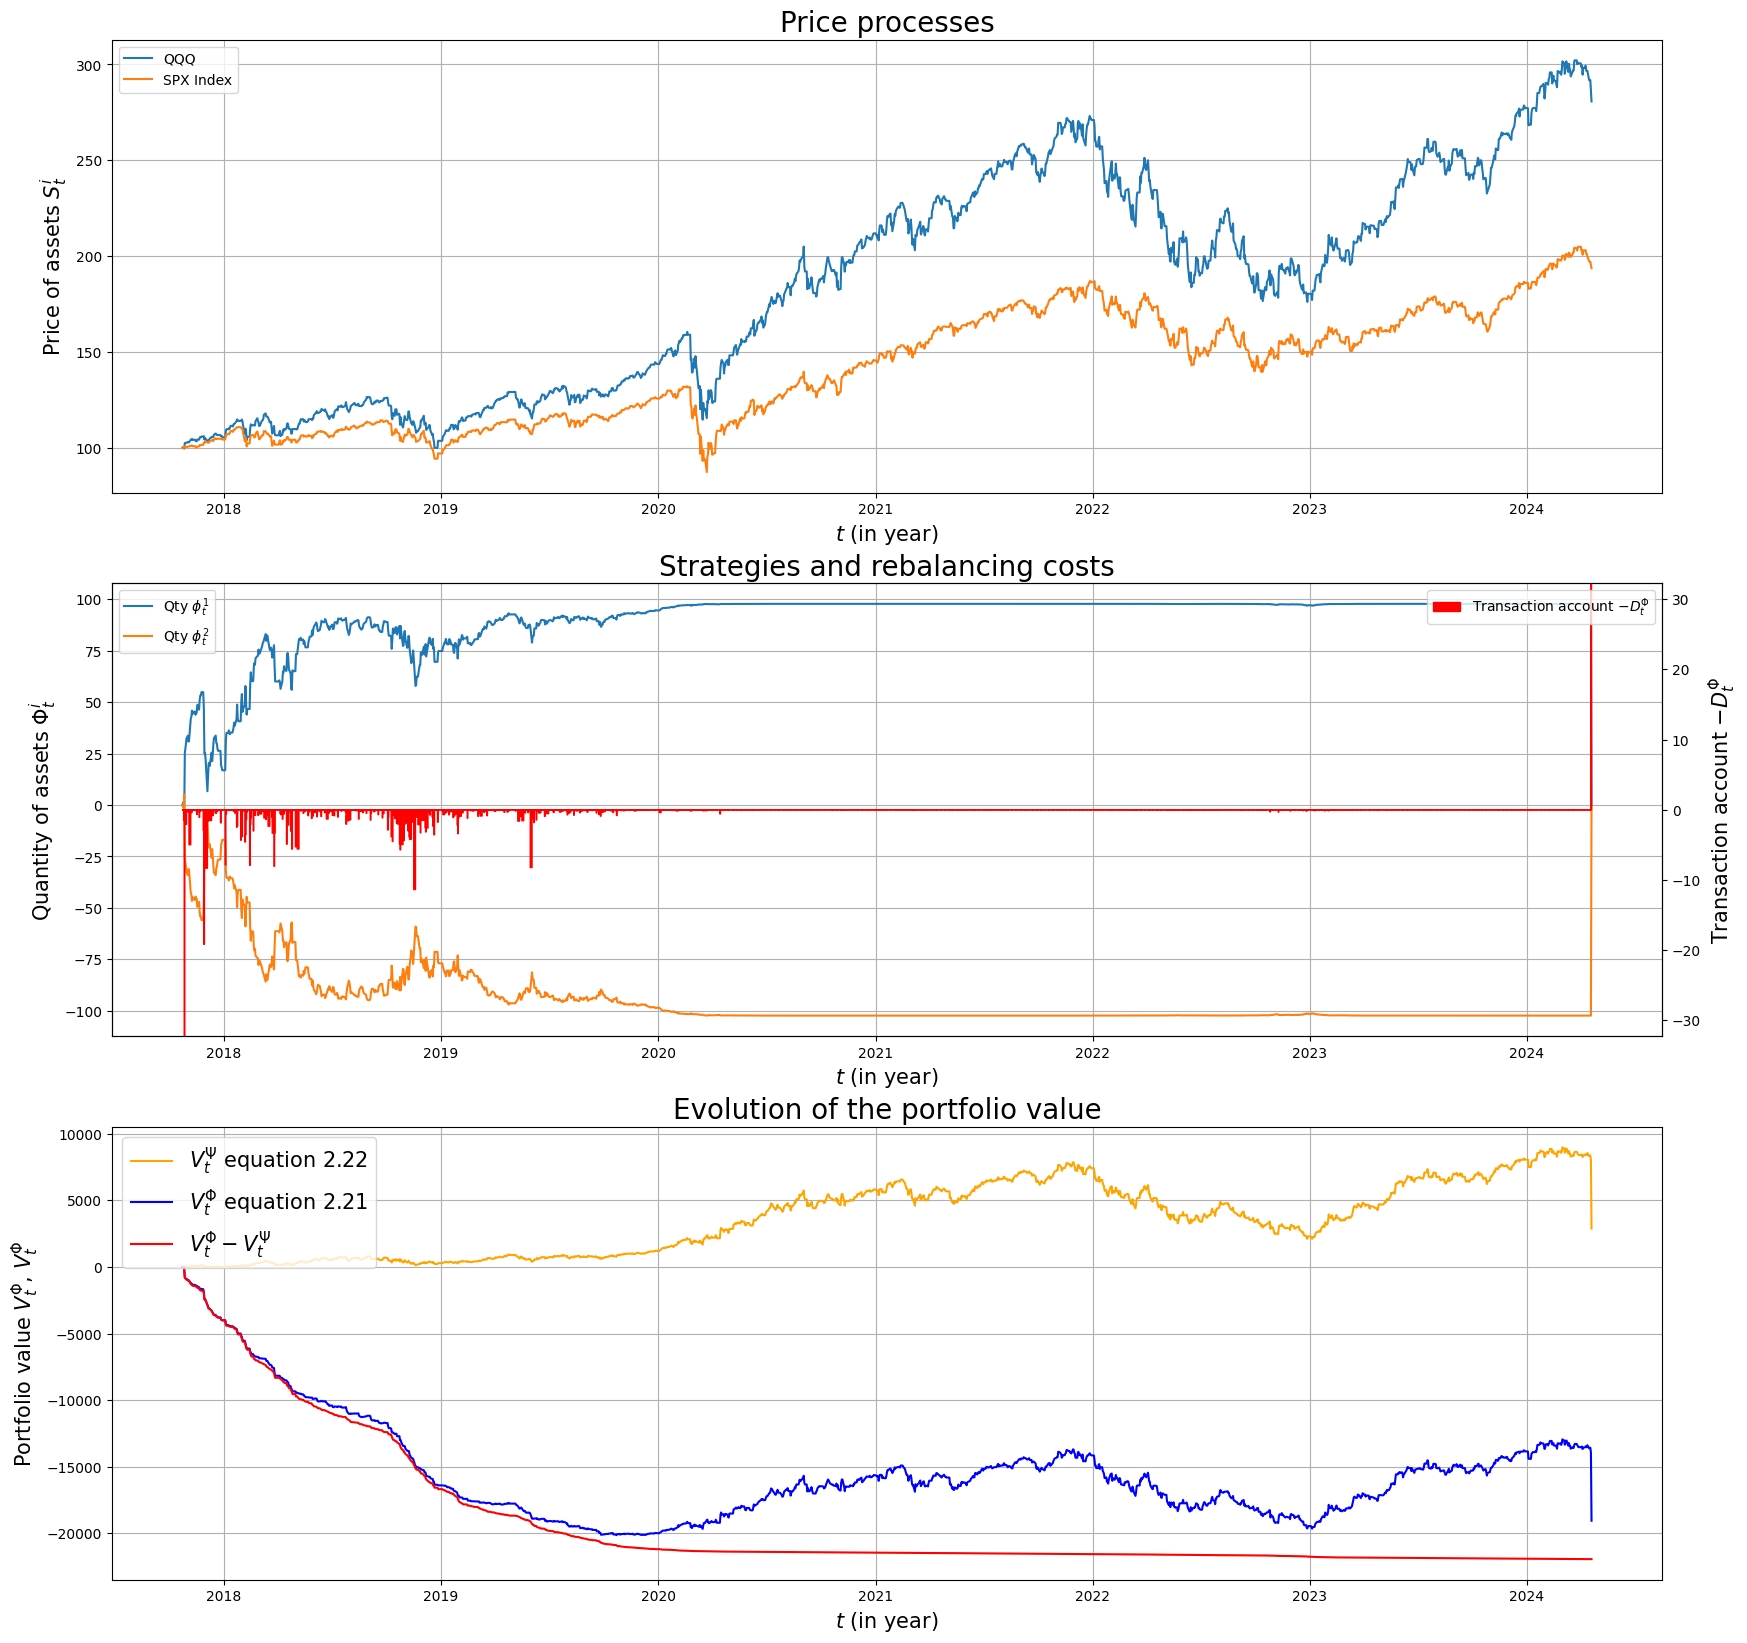

In [14]:
_, ax = plt.subplots(3, 1, figsize=(20, 20))
for col in df_backtest.columns:
    ax[0].plot(
        df_backtest[col],
        label=f"{col}",
    )

ax[0].set_xlabel("$t$ (in year)", fontsize=15)
ax[0].set_ylabel("Price of assets $S_t^i$", fontsize=15)
ax[0].set_title(f"Price processes", fontsize=20)
ax[0].grid()
ax[0].legend(fontsize=10)

for col in weights_df.columns:
    ax[1].plot(
        weights_df[col],
        label=r"Qty $\{}_t$".format(col.replace("_", "^")),
    )
ax_l = ax[1].twinx()
ax_l.fill_between(
    df_backtest.index,
    -transaction_account,
    color="red",
    step="pre",
    label=r"Transaction account $-D_t^\Phi$",
)

ax[1].set_xlabel("$t$ (in year)", fontsize=15)
ax[1].set_ylabel(r"Quantity of assets $\Phi_t^i$", fontsize=15)
ax_l.set_ylabel(r"Transaction account $-D_t^\Phi$", fontsize=15)
ax_l.set_ylim([-max(transaction_account), max(transaction_account)])
ax[1].set_title(f"Strategies and rebalancing costs", fontsize=20)
ax[1].grid()
ax[1].legend(fontsize=10, loc="upper left")
ax_l.legend(fontsize=10, loc="upper right")
# ax_l2 = ax[2].twinx()
ax[2].plot(df_backtest.index, V_t_psi, label=r"$V_t^\Psi$ equation 2.22", color="orange")
ax[2].plot(
    df_backtest.index,
    V_t_phi,
    # linestyle="--",
    label=r"$V_t^\Phi$ equation 2.21",
    color="blue",
)
ax[2].plot(
    df_backtest.index,
    V_t_phi - V_t_psi,
    label=r"$V_t^\Phi-V_t^\Psi$",
    color="red",
)

ax[2].set_xlabel("$t$ (in year)", fontsize=15)
ax[2].set_ylabel(r"Portfolio value $V_t^\Phi$, $V_t^\Phi$", fontsize=15)
ax[2].set_title(f"Evolution of the portfolio value", fontsize=20)
ax[2].grid()
# ax_l2.legend(fontsize=15, loc="upper left")
ax[2].legend(fontsize=15, loc="upper left")

In [6]:
from warnings import filterwarnings
filterwarnings("ignore")
for ticker in set((
    "^IBEX",
    "GBP=X",
    "SI=F",
    "NG=F",
    "^GDAXI",
    "^N225",
    "^TNX",
    "TTF=F",
    "^AEX",
    "EURUSD=X",
    "^FVX",
    "^TYX",
    "^DJI",
    "JPYUSD=X",
    "^NSEI",
    "GC=F",
    "HTT=F",
    "BZ=F",
    "QQQ",
    "BTC-USD",
)):
	data = yfinance.download(
	tickers=[ticker], 
	period="60d",interval="30m")# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo


	data['Close'] = (data.dropna().Close.pct_change().fillna(99) + 1).cumprod()

	t = generate_t(data.shape[0], T=(data.index[-1]-data.index[0]).days / 252)

	print(f"{ticker} : H={compute_empirical_hurst_exponent(data['Close'].to_numpy(),t):.5f}")

[*********************100%%**********************]  1 of 1 completed


^FVX : H=0.49844


[*********************100%%**********************]  1 of 1 completed


QQQ : H=0.53284


[*********************100%%**********************]  1 of 1 completed


GBP=X : H=0.53282


[*********************100%%**********************]  1 of 1 completed


^AEX : H=0.45438


[*********************100%%**********************]  1 of 1 completed


^NSEI : H=0.57666


[*********************100%%**********************]  1 of 1 completed


JPYUSD=X : H=0.49702


[*********************100%%**********************]  1 of 1 completed


EURUSD=X : H=0.53745


[*********************100%%**********************]  1 of 1 completed


HTT=F : H=0.19056


[*********************100%%**********************]  1 of 1 completed


NG=F : H=0.41506


[*********************100%%**********************]  1 of 1 completed


^TYX : H=0.52017


[*********************100%%**********************]  1 of 1 completed


BZ=F : H=0.48563


[*********************100%%**********************]  1 of 1 completed


SI=F : H=0.56031


[*********************100%%**********************]  1 of 1 completed


^TNX : H=0.50659


[*********************100%%**********************]  1 of 1 completed


^DJI : H=0.46425


[*********************100%%**********************]  1 of 1 completed


^IBEX : H=0.62451


[*********************100%%**********************]  1 of 1 completed


^GDAXI : H=0.52239


[*********************100%%**********************]  1 of 1 completed


GC=F : H=0.52845


[*********************100%%**********************]  1 of 1 completed


^N225 : H=0.50091


[*********************100%%**********************]  1 of 1 completed


BTC-USD : H=0.56203


[*********************100%%**********************]  1 of 1 completed

TTF=F : H=0.41628


In [14]:
from warnings import filterwarnings

data = yfinance.download(
tickers=["^IBEX",
    "GBP=X",
    "SI=F",
    "NG=F",
    "^GDAXI",
    "^N225",
    "^TNX",
    "TTF=F",
    "^AEX",
    "EURUSD=X",
    "^FVX",
    "^TYX",
    "^DJI",
    "JPYUSD=X",
    "^NSEI",
    "GC=F",
    "HTT=F",
    "BZ=F",
    "QQQ",
    "BTC-USD",], 
period="60d",interval="30m")# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo


data = data.ffill().dropna().Close # (data.dropna().Close.pct_change().fillna(99) + 1).cumprod()

t = generate_t(data.shape[0], T=(data.index[-1]-data.index[0]).days / 252)
for col in data.columns:
    print(f"{col} : H={compute_empirical_hurst_exponent(data[col].to_numpy(),t):.5f}")

[*********************100%%**********************]  20 of 20 completed


BTC-USD : H=0.46738
BZ=F : H=0.52693
EURUSD=X : H=0.51135
GBP=X : H=0.54497
GC=F : H=0.42553
HTT=F : H=0.51136
JPYUSD=X : H=0.41607
NG=F : H=0.50842
QQQ : H=0.46092
SI=F : H=0.42963
TTF=F : H=0.26693
^AEX : H=0.45560
^DJI : H=0.45389
^FVX : H=0.51470
^GDAXI : H=0.55166
^IBEX : H=0.54174
^N225 : H=0.50524
^NSEI : H=0.56262
^TNX : H=0.50660
^TYX : H=0.51740


In [15]:
ALPHA = -30
BETA = 30

# fees (no fees now)
P1 = 0.1  # 0.1 proportionality factor p1 (in percent)
P2 = 0.5  # 0.5 minimum fee p2 (in monetary units)

SCALING_FACTOR = 100  # \gamma


salopek_strat = SalopekStrategy(alpha=ALPHA, beta=BETA)

df_backtest = (data[["^GDAXI","^IBEX"]].dropna().pct_change().fillna(0)+1).cumprod()
bk_tester = Backtester()

weights_df, V_t_psi, V_t_phi, transaction_account = bk_tester.run_backtest(
    universe_dataframe=df_backtest,
    allocation_function=salopek_strat.get_allocation,
    p1=P1,
    p2=P2,
)

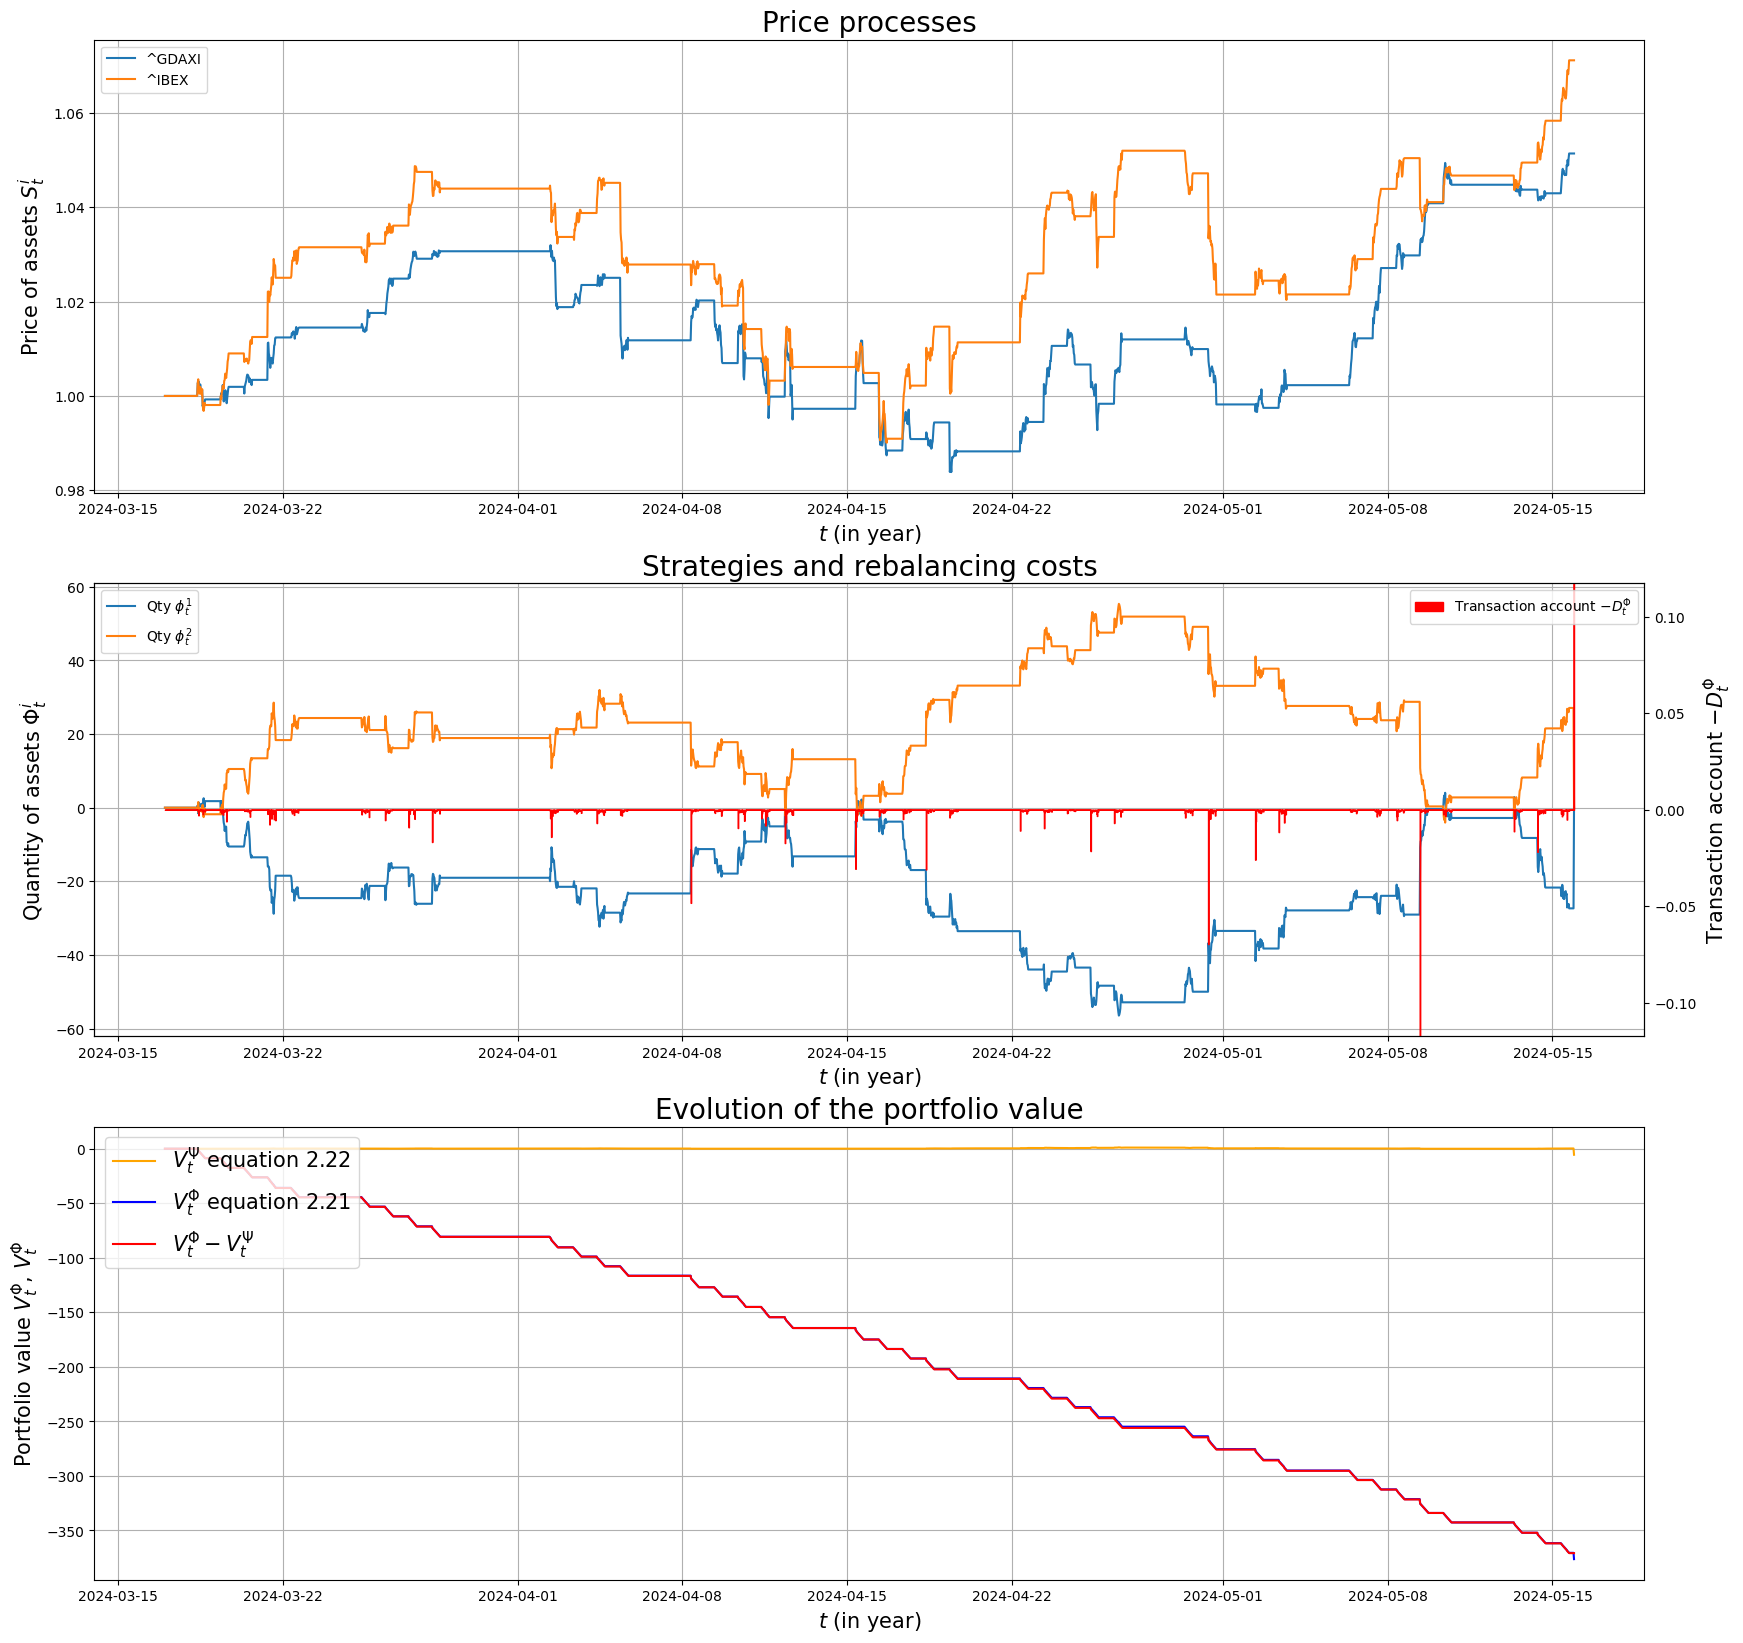

In [16]:
_, ax = plt.subplots(3, 1, figsize=(20, 20))
for col in df_backtest.columns:
    ax[0].plot(
        df_backtest[col],
        label=f"{col}",
    )

ax[0].set_xlabel("$t$ (in year)", fontsize=15)
ax[0].set_ylabel("Price of assets $S_t^i$", fontsize=15)
ax[0].set_title(f"Price processes", fontsize=20)
ax[0].grid()
ax[0].legend(fontsize=10)

for col in weights_df.columns:
    ax[1].plot(
        weights_df[col],
        label=r"Qty $\{}_t$".format(col.replace("_", "^")),
    )
ax_l = ax[1].twinx()
ax_l.fill_between(
    df_backtest.index,
    -transaction_account,
    color="red",
    step="pre",
    label=r"Transaction account $-D_t^\Phi$",
)

ax[1].set_xlabel("$t$ (in year)", fontsize=15)
ax[1].set_ylabel(r"Quantity of assets $\Phi_t^i$", fontsize=15)
ax_l.set_ylabel(r"Transaction account $-D_t^\Phi$", fontsize=15)
ax_l.set_ylim([-max(transaction_account), max(transaction_account)])
ax[1].set_title(f"Strategies and rebalancing costs", fontsize=20)
ax[1].grid()
ax[1].legend(fontsize=10, loc="upper left")
ax_l.legend(fontsize=10, loc="upper right")
# ax_l2 = ax[2].twinx()
ax[2].plot(df_backtest.index, V_t_psi, label=r"$V_t^\Psi$ equation 2.22", color="orange")
ax[2].plot(
    df_backtest.index,
    V_t_phi,
    # linestyle="--",
    label=r"$V_t^\Phi$ equation 2.21",
    color="blue",
)
ax[2].plot(
    df_backtest.index,
    V_t_phi - V_t_psi,
    label=r"$V_t^\Phi-V_t^\Psi$",
    color="red",
)

ax[2].set_xlabel("$t$ (in year)", fontsize=15)
ax[2].set_ylabel(r"Portfolio value $V_t^\Phi$, $V_t^\Phi$", fontsize=15)
ax[2].set_title(f"Evolution of the portfolio value", fontsize=20)
ax[2].grid()
# ax_l2.legend(fontsize=15, loc="upper left")
ax[2].legend(fontsize=15, loc="upper left")